In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

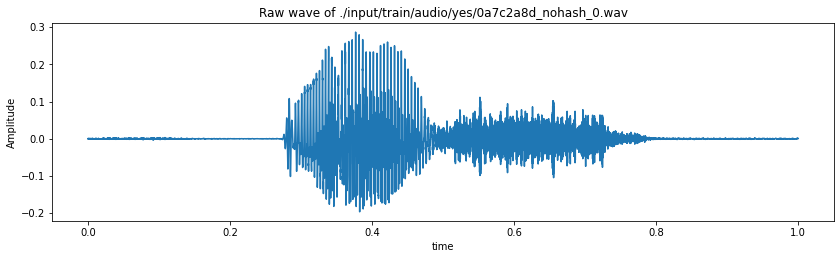

In [2]:
train_audio_path = './input/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + './input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [3]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


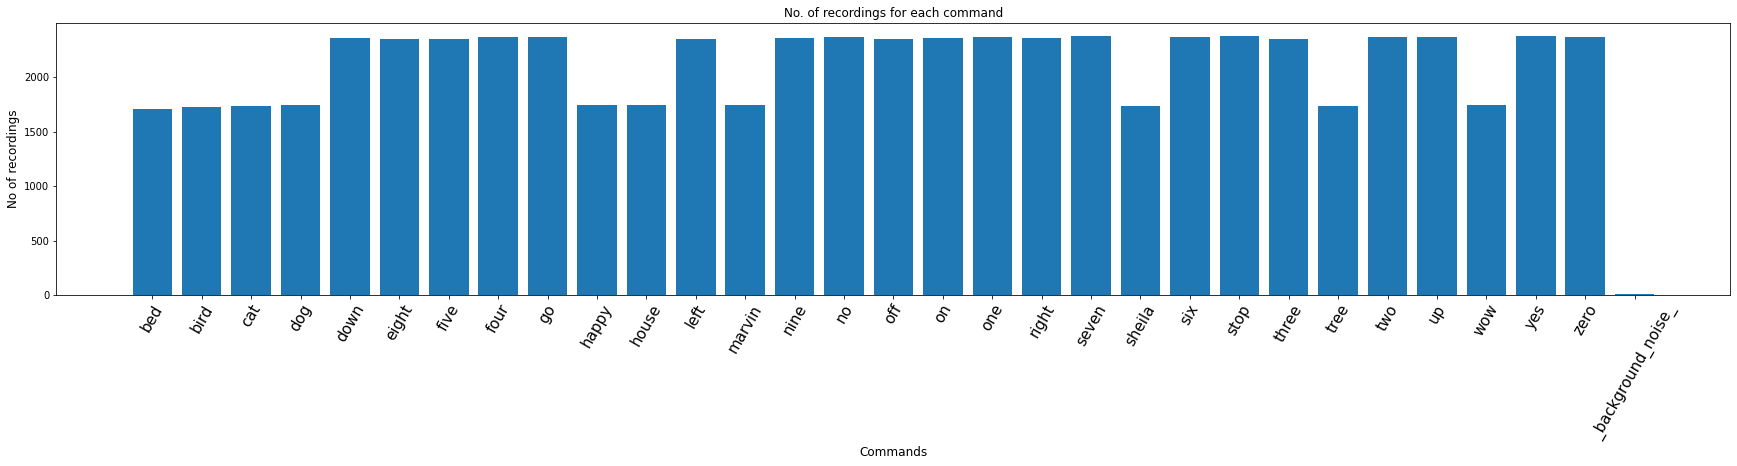

In [4]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

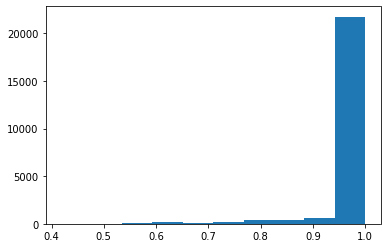

In [5]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [6]:
train_audio_path = './input/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [7]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [8]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [9]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [10]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [14]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - ETA: 0s - loss: 2.0829 - accuracy: 0.2086
Epoch 00001: val_accuracy improved from -inf to 0.36875, saving model to best_model.hdf5
533/533 [==============================] - 59s 111ms/step - loss: 2.0829 - accuracy: 0.2086 - val_loss: 1.7147 - val_accuracy: 0.3688
Epoch 2/100
533/533 [==============================] - ETA: 0s - loss: 1.5472 - accuracy: 0.4204
Epoch 00002: val_accuracy improved from 0.36875 to 0.51232, saving model to best_model.hdf5
533/533 [==============================] - 56s 105ms/step - loss: 1.5472 - accuracy: 0.4204 - val_loss: 1.3559 - val_accuracy: 0.5123
Epoch 3/100
533/533 [==============================] - ETA: 0s - loss: 1.2940 - accuracy: 0.5324
Epoch 00003: val_accuracy improved from 0.51232 to 0.62163, saving model to best_model.hdf5
533/533 [==============================] - 57s 106ms/step - loss: 1.2940 - accuracy: 0.5324 - val_loss: 1.0883 - val_accuracy: 0.6216
Epoch 4/100
533/533 [=============

Epoch 28/100
533/533 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8782
Epoch 00028: val_accuracy did not improve from 0.84354
533/533 [==============================] - 79s 148ms/step - loss: 0.3474 - accuracy: 0.8782 - val_loss: 0.5575 - val_accuracy: 0.8269
Epoch 29/100
533/533 [==============================] - ETA: 0s - loss: 0.3535 - accuracy: 0.8769
Epoch 00029: val_accuracy did not improve from 0.84354
533/533 [==============================] - 80s 150ms/step - loss: 0.3535 - accuracy: 0.8769 - val_loss: 0.5571 - val_accuracy: 0.8271
Epoch 30/100
533/533 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8838
Epoch 00030: val_accuracy did not improve from 0.84354
533/533 [==============================] - 80s 151ms/step - loss: 0.3357 - accuracy: 0.8838 - val_loss: 0.5383 - val_accuracy: 0.8330
Epoch 31/100
533/533 [==============================] - ETA: 0s - loss: 0.3367 - accuracy: 0.8824
Epoch 00031: val_accuracy did not improve

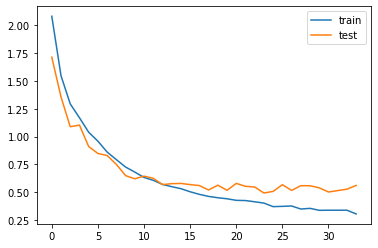

In [15]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
from keras.models import load_model
model=load_model('best_model.hdf5')

In [17]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [18]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: up


In [19]:
print("Text:",predict(samples))

Text: up


In [20]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 2 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


os.listdir('./input/voice-commands')

In [21]:
filepath='./input/voice_commands'

In [24]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'new.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

In [25]:
predict(samples)

'down'